In [1]:
%load_ext autoreload
%autoreload 2

import os

import copy

import numpy as np
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack

from mrf.display import display_single, SEG_CMAP

plt.rcParams['text.usetex'] = True

### Here we degrade the high-resolution image as an substitution of low-res image.

In [2]:
from mrf.download import download_decals_cutout

In [3]:
import astropy.units as u

LSBG-750: https://ui.adsabs.harvard.edu/abs/2018ApJ...866..112G/abstract

In [4]:
download_decals_cutout(179.9315, -0.77272222, 3000, 'r')
download_decals_cutout(179.9315, -0.77272222, 3000, 'g')

DECaLS_img_r.fits: 36.0MB [00:07, 4.87MB/s]                              
DECaLS_img_g.fits: 0.00B [00:00, ?B/s]

# Downloading DECaLS_img_r.fits finished! 


DECaLS_img_g.fits: 36.0MB [00:07, 4.86MB/s]                              

# Downloading DECaLS_img_g.fits finished! 


## Bin high-resolution image

In [14]:
from mrf.celestial import Celestial
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
from astropy.modeling.functional_models import Sersic2D, Gaussian2D

In [5]:
for filt in ['g', 'r']:
    hdu = fits.open('DECaLS_img_{}.fits'.format(filt))
    hires = Celestial(hdu[0].data, header=hdu[0].header)
    hdu.close()
    hires.resize_image(0.5, method='iraf')
    hires.image = convolve(hires.image, Gaussian2DKernel(1))
    hires.save_to_fits('LSBG_hires_{}_bin.fits'.format(filt));

## Make fake low-res image by convolving a Gaussian

In [34]:
for filt in ['g', 'r']:
    hdu = fits.open('DECaLS_img_{}.fits'.format(filt))
    a = fits.PrimaryHDU(data=hdu[0].data, header=hdu[0].header)
    hires = Celestial(a.data, header=a.header)
    hdu.close()
    
    size = 200
    #m_sersic = Gaussian2D(amplitude=1, x_mean=size, y_mean=size, x_stddev=10, y_stddev=10)
    m_sersic = Sersic2D(r_eff=12, n=1, x_0=size, y_0=size)
    y, x = np.mgrid[:(size * 2 + 1), :(size * 2 + 1)]
    sersic_kernel = m_sersic(x, y)
    sersic_kernel /= np.sum(sersic_kernel) # normalize
    fakeDF = convolve_fft(hires.image, kernel=sersic_kernel, allow_huge=True)
    hires.image = fakeDF
    hires.resize_image(hires.pixel_scale / 2.5, method='iraf')
    hires.save_to_fits('LSBG_lowres_{}.fits'.format(filt))

### Implement `mrf` task by providing directories of input images, along with galaxies you want to retain during `mrf`.

In [35]:
from mrf.task import MrfTask
task = MrfTask('LSBG-task-selfmrf-decals.yaml')
img_lowres = 'LSBG_lowres_r.fits'
img_hires_b = 'LSBG_hires_g_bin.fits'
img_hires_r = 'LSBG_hires_r_bin.fits'
certain_gal_cat = 'gal_cat_LSBG.txt'
results = task.run(img_lowres, img_hires_b, img_hires_r, certain_gal_cat, 
                   output_name='LSBG_r', verbose=True)

2019-10-22 00:32:08,111 Running Multi-Resolution Filtering (MRF) on "DECaLS" and "df" images!
2019-10-22 00:32:08,126 Magnify Dragonfly image with a factor of 3.0:
2019-10-22 00:32:08,290 Register high resolution image "LSBG_hires_g_bin.fits" with "LSBG_lowres_r.fits"
2019-10-22 00:32:08,690 Register high resolution image "LSBG_hires_r_bin.fits" with "LSBG_lowres_r.fits"
2019-10-22 00:32:09,113 Build flux models on high-resolution images: Blue band
2019-10-22 00:32:09,114     - sigma = 3.0, minarea = 2
2019-10-22 00:32:09,115     - deblend_cont = 0.00100, deblend_nthres = 32.0
2019-10-22 00:32:09,260     - Detect 1890 objects
2019-10-22 00:32:09,572 Build flux models on high-resolution images: Red band
2019-10-22 00:32:09,573     - sigma = 3.0, minarea = 2
2019-10-22 00:32:09,574     - deblend_cont = 0.00100, deblend_nthres = 32.0
2019-10-22 00:32:09,720     - Detect 1861 objects
2019-10-22 00:32:10,045 Make color correction to blue band, remove artifacts as well
2019-10-22 00:32:10,06

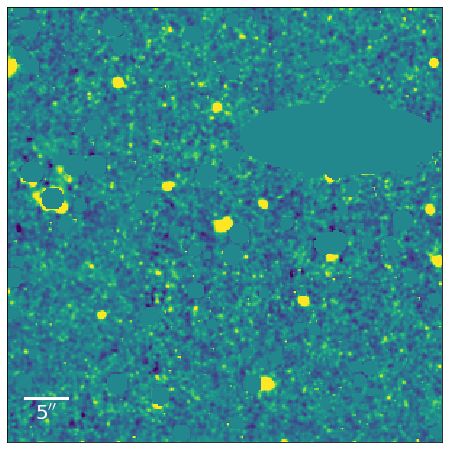

In [31]:
from mrf.utils import adjust_mask
results = adjust_mask(results, gaussian_radius=1.5, gaussian_threshold=0.005, bright_lim=14, r=13)

## Demo results

In [8]:
from mrf.utils import img_cutout

In [18]:
ra, dec = 179.9315, -0.77272222

In [32]:
hdu = fits.open('./LSBG_r_final.fits')
mrf_r = img_cutout(hdu[0].data, wcs.WCS(hdu[0].header), ra, dec, size=250, prefix='mrf_r')
hdu.close()

hdu = fits.open('./DECaLS_img_r.fits')
decals_r = img_cutout(hdu[0].data, wcs.WCS(hdu[0].header), ra, dec, 
                      pixel_scale=0.262, size=250, prefix='decals_r')
hdu.close()

hdu = fits.open('./LSBG_lowres_r.fits')
lowres_r = img_cutout(hdu[0].data, wcs.WCS(hdu[0].header), ra, dec, 
                      pixel_scale=2.5, size=250, prefix='lowres_r')
hdu.close()

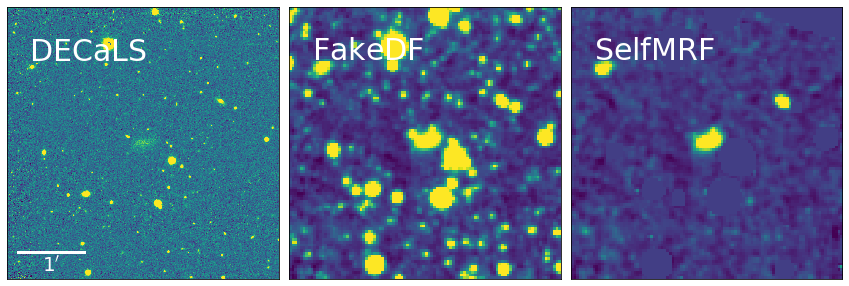

In [33]:
from mrf.display import display_multiple
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5))
ax1 = display_single(decals_r[0].data, ax=ax1, add_text='DECaLS', 
                     pixel_scale=0.262, scale_bar_length=61, scale_bar_y_offset=0.25)
display_multiple([lowres_r[0].data, mrf_r[0].data], ax=[ax2, ax3], text=['FakeDF', 'SelfMRF'], scale_bar=False)

plt.subplots_adjust(wspace=0.03)

#plt.savefig('LSBG-750-self-mrf.png', bbox_inches='tight')